<a href="https://colab.research.google.com/github/tsjannoun123-netizen/AI-for-Med.Diagnos.-Prediction-AAI_643O_O11_202610/blob/main/AI_for_Med_Diagnos_Prediction_Saera_Rawas_Project_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project - AI for Medical Diagnosis and Prediction | Week #2

In this notebook, we begin our analysis of the MIMIC-CXR dataset by exploring, cleaning, and organizing the data. The objective is to prepare a high-quality dataset for downstream tasks in machine learning and deep learning.

We will use a subset of the **MIMIC-CXR dataset** **[1][2]**. The MIMIC Chest X-ray (MIMIC-CXR) Database v2.0.0 is a large, publicly available dataset of chest radiographs in DICOM format, accompanied by free-text radiology reports. It contains 377,110 images from 227,835 radiographic studies conducted at the Beth Israel Deaconess Medical Center in Boston, MA. The dataset has been de-identified in compliance with the US Health Insurance Portability and Accountability Act of 1996 (HIPAA) Safe Harbor requirements. All protected health information (PHI) has been removed. More details: [https://mimic.mit.edu/docs/iv/modules/cxr/](https://mimic.mit.edu/docs/iv/modules/cxr/)

<div class="alert alert-block alert-info">
<b>Your tasks are the following:</b>  <br>
- Load and examine the dataset structure and contents <i>(Task 1)</i> <br>
- Clean the metadata by removing or imputing missing values <i>(Task 2)</i> <br>
- Anonymize DICOM images if necessary <i>(Task 2*)</i> <br>
- Extract informative features from images and radiology reports <i>(Task 3)</i> <br>
- Standardize features and identify outliers <i>(Task 4)</i> <br>
- Apply dimensionality reduction (PCA, t-SNE) to visualize the feature space <i>(Task 5)</i> <br>
- Select and store the most relevant features for model training <i>(Task 5)</i> <br>
</div>

**[1]** Johnson, A., Pollard, T., Mark, R., Berkowitz, S., & Horng, S. (2024). MIMIC-CXR Database (version 2.1.0). PhysioNet. [https://doi.org/10.13026/4jqj-jw95](https://doi.org/10.13026/4jqj-jw95).

**[2]** Johnson, A.E.W., Pollard, T.J., Berkowitz, S.J. et al. MIMIC-CXR, a de-identified publicly available database of chest radiographs with free-text reports. Sci Data 6, 317 (2019). [https://doi.org/10.1038/s41597-019-0322-0](https://doi.org/10.1038/s41597-019-0322-0)

In [1]:
# retrieve the content from the repository
!git clone https://github.com/albarqounilab/AIM.git

Cloning into 'AIM'...
remote: Enumerating objects: 905, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 905 (delta 2), reused 8 (delta 2), pack-reused 889 (from 2)
Receiving objects: 100% (905/905), 208.70 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (246/246), done.
Updating files: 100% (87/87), done.


In [2]:
# install dependencies
!pip install pydicom pynrrd SimpleITK pyradiomics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 25.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 69.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import pydicom
import nrrd

import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from glob import glob
from radiomics import featureextractor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

import sys
sys.path.append('/content/AIM/')
from utils.sitk_utils import load_dicom_series_to_3d_image, convert_np_to_sitk, reconstruct_mask_in_image_space

In [4]:
#DATA_PATH = '../data/MIMIC-CXR'
DATA_PATH = "/content/data/MIMIC-CXR"

In [5]:
import os
# make sure the directory exists
os.makedirs(DATA_PATH, exist_ok=True)

Run the following cells to download and unzip the dataset.

<div class="alert alert-block alert-danger">
<b>Replace the <code>DATA_PATH</code> with the path where you want to store the folder. By default, it will be stored in the data folder at the root of the directory.</b> <br>
<b>If you have already downloaded the dataset, comment the following cell by adding a <code>#</code> before the <code>!</code></b>
</div>

In [6]:
# download and save the file as MIMIC-CXR.zip
!wget -O {DATA_PATH}/MIMIC-CXR.zip https://uni-bonn.sciebo.de/s/YHuwFOg6q6sw1ZX/download

# unzip into the same directory
!unzip -q {DATA_PATH}/MIMIC-CXR.zip -d {DATA_PATH}

--2025-09-15 08:07:17--  https://uni-bonn.sciebo.de/s/YHuwFOg6q6sw1ZX/download
Resolving uni-bonn.sciebo.de (uni-bonn.sciebo.de)... 128.176.1.2
Connecting to uni-bonn.sciebo.de (uni-bonn.sciebo.de)|128.176.1.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8281720521 (7.7G) [application/zip]
Saving to: ‘/content/data/MIMIC-CXR/MIMIC-CXR.zip’

/content/data/MIMIC 100%[===================>]   7.71G  76.2MB/s    in 96s     

2025-09-15 08:08:53 (82.7 MB/s) - ‘/content/data/MIMIC-CXR/MIMIC-CXR.zip’ saved [8281720521/8281720521]



In [7]:
#!wget https://uni-bonn.sciebo.de/s/YHuwFOg6q6sw1ZX/download --output {DATA_PATH}/MIMIC-CXR.zip
#!unzip {DATA_PATH}/MIMIC-CXR.zip

## Task 1: Data Exploration

<div class="alert alert-block alert-info">
<b>1.</b> Load the different csv files contained in the dataset and explore their content.
</div>

In [8]:
#redifine Data path
DATA_PATH = "/content/data/MIMIC-CXR/MIMIC-CXR"

In [9]:
study_df = pd.read_csv(f'{DATA_PATH}/cxr-study-list.csv.gz') # COMPLETE with correct filenames
record_df = pd.read_csv(f'{DATA_PATH}/cxr-record-list.csv.gz')
provider_df = pd.read_csv(f'{DATA_PATH}/cxr-provider-list.csv.gz')
mask_df = pd.read_csv(f'{DATA_PATH}/cxr-mask-list.csv')

Each file provide different information about the dataset.

* `study_df` contains patients and study ids with the corresponding radiology reports ;
* `record_df` contains patients and study ids with corresponding DICOM ids and image paths ;
* `provider_df` contains ids of data providers ;
* `mask_df` contains the patients and study ids with paths to their corresponding masks.

<div class="alert alert-block alert-info">
<b>2.</b> Search for available image (<code>record</code>), segmentation (<code>mask</code>) and report (<code>study</code>) files in the directory. Create dataframes containing only the information about the subjects with available files. Name these dataframe <code>subset_{df_name}</code>.
</div>

In [10]:
# Get list of image paths of available data
file_list = glob(f'{DATA_PATH}/files/*/*/*/*.dcm') # Path to images. Use * to search within all folders.
file_list = [f[len(DATA_PATH)+1:] for f in file_list]

# Get subset csv files with only information on available subjects
subset_record_df = record_df.loc[record_df['path'].isin(file_list)]
subset_record_df.head()

,subject_id,study_id,dicom_id,path
301504,18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,files/p18/p18000291/s55388853/04564240-d4e9e69...
301505,18000291,55388853,a17c02b3-7c360f2c-a07734a0-76867697-36d59d3d,files/p18/p18000291/s55388853/a17c02b3-7c360f2...
301506,18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,files/p18/p18000291/s55388853/ed82a88d-499bed8...
301507,18000379,51062789,4885a037-6d0efe8b-97d2955b-eb046c9f-3f5d89b6,files/p18/p18000379/s51062789/4885a037-6d0efe8...
301508,18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...


In [11]:
## Get list of available reports
file_study_list = glob(f'{DATA_PATH}/files/*/*/*.txt') # COMPLETE with path to text reports.
file_study_list = [f[len(DATA_PATH)+1:] for f in file_study_list]

# Get subset csv files with only information on available subjects
subset_study_df = study_df.loc[study_df['path'].isin(file_study_list)] # COMPLETE to select only samples with study_df['path'] in file_study_list
subset_study_df.head()


,subject_id,study_id,path
182076,18000291,55388853,files/p18/p18000291/s55388853.txt
182077,18000379,51062789,files/p18/p18000379/s51062789.txt
182078,18000379,51568340,files/p18/p18000379/s51568340.txt
182079,18000379,51817182,files/p18/p18000379/s51817182.txt
182080,18000379,53632378,files/p18/p18000379/s53632378.txt


In [12]:
# Get list of available masks
file_mask_list = glob(f'{DATA_PATH}/segmentation/*/*/*.png')  # COMPLETE with path to masks in png format.
file_mask_list = [f[len(DATA_PATH)+1:] for f in file_mask_list]

subset_mask_df = mask_df.loc[mask_df['mask_path'].isin(file_mask_list)] # COMPLETE to select only samples with mask_df['mask_path'] in file_mask_list
subset_mask_df.head()


,subject_id,study_id,mask_path,dicom_id
0,18000291,55388853,segmentation/18000291/55388853/04564240-d4e9e6...,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743
1,18000291,55388853,segmentation/18000291/55388853/ed82a88d-499bed...,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee
2,18000379,51062789,segmentation/18000379/51062789/eac2b8fa-9245fe...,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b
3,18000379,51568340,segmentation/18000379/51568340/3631ff3b-cfcb24...,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb
4,18000379,51817182,segmentation/18000379/51817182/f6f04111-c3fde2...,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2


## Task 2: Data Cleaning

Now, we will merge the three dataframes to keep only the rows corresponding to images with:
* Available DICOM file;
* Available report;
* Available segmentation mask.

In [13]:
metadata_df = pd.merge(subset_record_df, subset_study_df, on=['study_id', 'subject_id'])
metadata_df = pd.merge(metadata_df, subset_mask_df, on=['study_id', 'subject_id','dicom_id'])
metadata_df.columns = ['subject_id', 'study_id', 'dicom_id', 'dicom_path', 'report_path', 'mask_path']

metadata_df.head()

,subject_id,study_id,dicom_id,dicom_path,report_path,mask_path
0,18000291,55388853,04564240-d4e9e69c-1dd70a83-14b463cd-b7614743,files/p18/p18000291/s55388853/04564240-d4e9e69...,files/p18/p18000291/s55388853.txt,segmentation/18000291/55388853/04564240-d4e9e6...
1,18000291,55388853,ed82a88d-499bed8a-de7539b2-417328ad-8aac20ee,files/p18/p18000291/s55388853/ed82a88d-499bed8...,files/p18/p18000291/s55388853.txt,segmentation/18000291/55388853/ed82a88d-499bed...
2,18000379,51062789,eac2b8fa-9245fe41-76c8951a-fe495dc0-a705cb9b,files/p18/p18000379/s51062789/eac2b8fa-9245fe4...,files/p18/p18000379/s51062789.txt,segmentation/18000379/51062789/eac2b8fa-9245fe...
3,18000379,51568340,3631ff3b-cfcb2447-6c718bec-2b6abe0c-9a3b4ecb,files/p18/p18000379/s51568340/3631ff3b-cfcb244...,files/p18/p18000379/s51568340.txt,segmentation/18000379/51568340/3631ff3b-cfcb24...
4,18000379,51817182,f6f04111-c3fde252-ab50a901-dda6e366-b227f9f2,files/p18/p18000379/s51817182/f6f04111-c3fde25...,files/p18/p18000379/s51817182.txt,segmentation/18000379/51817182/f6f04111-c3fde2...


<div class="alert alert-block alert-info">
<b>3.</b> Load one of the DICOM image. Observe the header and locate potential metadata that require anonymization.
</div>

In [14]:
image_fname = f'{DATA_PATH}/' + metadata_df.iloc[0]['dicom_path']
image = pydicom.dcmread(image_fname) # COMPLETE with pydicom function to read the image
image

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 204
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002,0003) Media Storage SOP Instance UID      UI: 2.25.5764793288502811401512973828422394829
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 2.25.55362949469033348352269585565668676650
(0002,0013) Implementation Version Name         SH: 'MIMIC-CXR v2.0.0'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008,0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation
(0008,0018) SOP Instance UID                    UI: 2.25.5764793288502811401512973828422394829
(0008,0

All necessary anonymization was already performed. But, we notice that a few elements from the headers could be interesting to add to our `metadata_df`. In particular:
* `ProcedureCodeSequence_CodeMeaning`
* `ViewCodeSequence_CodeMeaning`
* `PatientOrientationCodeSequence_CodeMeaning`

We will extract these information for all available DICOM files and integrate them to the dataframe.

In [15]:
# Place holder lists for metadata
procedure = []
view = []

for dcm_file in metadata_df['dicom_path']:
    image = pydicom.dcmread(f'{DATA_PATH}/' + dcm_file)

    if image.get_item('ProcedureCodeSequence'): # Search for the ProcedureCodeSequence item in DICOM header
        procedure.append(image.ProcedureCodeSequence[0].CodeMeaning) # Add the CodeMeaning value to procedure list
    else:
        procedure.append(np.nan) # Input NaN

    # COMPLETE : Do the same with the CodeMeaning value of the ViewCodeSequence item. Append it to the view list.
    if image.get_item('ViewCodeSequence'): # Search for the ViewCodeSequence item in DICOM header
        view.append(image.ViewCodeSequence[0].CodeMeaning) # Add the CodeMeaning value to view list
    else: # If not available
        view.append(np.nan) # Add np.nan to the view list

metadata_df['ProcedureCodeSequence_CodeMeaning'] = procedure
metadata_df['ViewCodeSequence_CodeMeaning'] = view

<div class="alert alert-block alert-info">
<b>4.</b> Save the cleaned dataframe as a csv file. Use the name <code>metadata_clean.csv`</code>.
</div>

In [16]:
metadata_df.to_csv('metadata_clean.csv') # COMPLETE with function to save the dataframe.

## Task 3: Feature Extraction

<div class="alert alert-block alert-info">
<b>6.</b> Load segmentation masks and run radiomic extraction. Check segmentation mask shape, if needed adjust extraction with mask relocation. Save the extracted features in a csv file named <code>features_raw.csv</code>.
</div>

In [17]:
settings = {}

# Normalizes the image by centering it at the mean with standard deviation.
# Normalization is based on all gray values in the image, not just those inside the segmentation.
settings['normalize'] = True
settings['label'] = 255

# COMPLETE : Create the featureextractor with the defined settings.
extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'normalize': True, 'label': 255}


In [18]:
feature_list = []

# Loop over patients
for i in range(len(metadata_df)):
    subject_id = metadata_df.iloc[i]['subject_id']
    study_id = metadata_df.iloc[i]['study_id']
    dicom_path = metadata_df.iloc[i]['dicom_path']
    mask_path = metadata_df.iloc[i]['mask_path']
    img_fname = glob(f'{DATA_PATH}/' + dicom_path)[0]
    seg_fname = glob(f'{DATA_PATH}/' + mask_path)[0]

    if len(img_fname) == 0 or len(seg_fname)==0:
        continue # Allows to skip subjects without image or without segmentation

    try:
        pixel_array = pydicom.dcmread(img_fname).pixel_array # Load
    except:
        continue
    image_sitk = sitk.GetImageFromArray(pixel_array)

    #pixel_array = pydicom.dcmread(img_fname).pixel_array # COMPLETE : Load image with pydicom and get pixel array
    #image_sitk = sitk.GetImageFromArray(pixel_array)

    reader = sitk.ImageFileReader() # Create a file reader
    reader.SetImageIO("PNGImageIO") # Set input type
    reader.SetFileName(seg_fname) # Set filename
    mask_sitk = reader.Execute() # Read

    result = extractor.execute(image_sitk, mask_sitk) # Execute the feature extraction

    result['subject_id'] = subject_id
    result['study_id'] = study_id
    result['dicom_path'] = dicom_path

    feature_list.append(result)

Streaming output truncated to the last 5000 lines.
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:Calculating features with label: 255
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:Adding image type "Original" with custom settings: {}
INFO:radiomics.featureextractor:Calculating features for original image
INFO:radiomics.featureextractor:Computing firstorder
INFO:radiomics.featureextractor:Computing glcm
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
INFO:radiomics.featureextractor:Computing gldm
INFO:radiomics.featureextractor:Computing glrlm
INFO:radiomics.featureextractor:Computing glszm
INFO:radiomics.featureextractor:Computing ngtdm
INFO:radiomics.featureextractor:Calculating features with label: 255
INFO:radiomics.featureextracto

In [20]:
# Gather all radiomics data into a df and save it
radiomics = pd.DataFrame()

for feature in feature_list:
  new_df = pd.DataFrame.from_dict(data=feature, orient='index')
  radiomics = pd.concat([radiomics, new_df.iloc[22:].T]) # Remove 22 first features which won't be useful (metadata)

radiomics.to_csv(f'features_raw.csv')

## Task 4: Target Label Extraction

Now, we will extract target labels corresponding to findings from radiology reports. We created a list of diagnosis of interest and functions to extract them. The goal is to be careful of negations such as `There is no evidence of pneumothorax.`.

<div class="alert alert-block alert-info">
<b>6.</b> Read a few reports and try to make an "almost" exhaustive list of potential negative formula. Add these to the <code>NEGATIONS</code> list.
</div>

In [21]:
import spacy
import csv

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

def is_chunk_negated(chunk):
    """
    Check if the noun chunk is governed by negation.
    Looks at negation tokens in or near the chunk's root.
    """
    # Check within chunk
    for token in chunk:
        if token.dep_ == "neg" or token.text.lower() in NEGATIONS:
            return True

    # Check to the left of the chunk root
    for token in chunk.root.lefts:
        if token.dep_ == "neg" or token.text.lower() in NEGATIONS:
            return True

    # Check ancestors of root (e.g., "without pleural effusion")
    for ancestor in chunk.root.ancestors:
        for child in ancestor.children:
            if child.dep_ == "neg" or child.text.lower() in NEGATIONS:
                return True

    return False

def extract_positive_findings(text):
    if "IMPRESSION:" in text:
        impression_text = text.split("IMPRESSION:")[1].strip()

    elif "FINDINGS" in text:
        impression_text = text.split("FINDINGS")[1].strip()

    else:
        impression_text = text.strip()

    doc = nlp(impression_text.lower())

    findings = []

    for chunk in doc.noun_chunks:
        chunk_text = chunk.text.strip().lower()
        word_in_text = [word for word in DIAGNOSIS_KEYWORDS if word in chunk_text]
        if any(word_in_text):
            if not is_chunk_negated(chunk):
                findings.extend(word_in_text)

    if findings == []:
        findings.append('no findings')

    return np.unique(findings).tolist()

def process_radiology_report(file_path):
    with open(file_path, 'r') as file:
        text = file.read()

    findings = extract_positive_findings(text)

    return findings

In [22]:
# Define basic diagnostic keywords (can be expanded)
DIAGNOSIS_KEYWORDS = [
    "atelectasis", "consolidation", "effusion", "pneumothorax", "edema",
    "infiltrate", "opacity", "fibrosis", "emphysema", "nodule", "mass"
    'cardiomegaly',	'enlargement',	'fracture',	'lesion', 'pneumonia'
]

NEGATIONS = ["no", "not", "without", "absent", "denies","negative for", "rule out", "free of",
    "lack of", "resolved", "excluded","neither", "never", "nor", "nothing","cannot be seen", "unremarkable for",
    "no evidence of", "no signs of"] # COMPLETE with other negation formula

In [23]:
labels = []
for reports in metadata_df['report_path']:
    report_file = f'{DATA_PATH}/'+ reports
    labels.append(process_radiology_report(report_file))

We have now extracted the labels from the radiology reports. For future use, we will need them to be encoded as binary attributes.
Since we are in a multi-output case where each image can contain more than one label, we will use the `MultiLabelBinarizer` function from scikit-learn. This function works similarly to other scikit-learn functions.

1. `mlb.fit(labels)`
2. `encoded_labels = mlb.transform(labels)`

<div class="alert alert-block alert-info">
<b>7.</b> Complete the following cells to encode the labels exported from the reports.
</div>

In [24]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

mlb.fit(labels)
encoded_labels = mlb.transform(labels)

labels_df = pd.DataFrame({
    'labels_encoded': list(encoded_labels),
    'pathology':[0 if 'no findings' in l else 1 for l in labels],
    'subject_id': metadata_df['subject_id'],
    'study_id': metadata_df['study_id'],
    'dicom_id': metadata_df['dicom_id']
})

labels_df.to_csv('labels.csv', index=False)

## Task 5: Data Visualization

<div class="alert alert-block alert-info">
<b>8.</b> Visualize the radiomic features using dimension reduction techniques. First, compute the low-dimensional representation of the radiomic features using 1) PCA, 2) t-SNE and 3) LDA. Then, visualize the scatter-plots of the features.
</div>

To color-code the plot with target labels, you can use one column at a time:
* First, start by visualizing `No findings` vs. others
* Then, do the same with any target label.

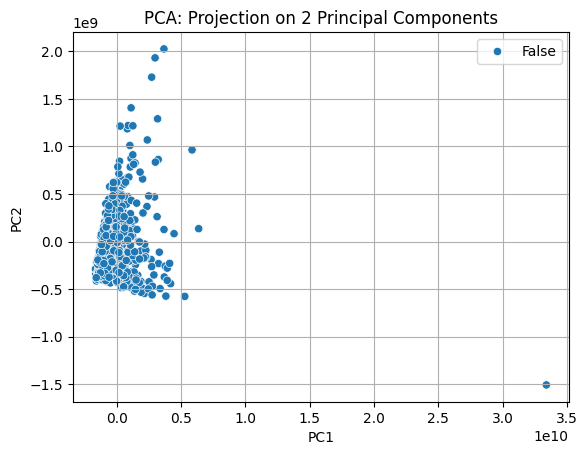

In [25]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(radiomics.drop(['subject_id', 'study_id', 'dicom_path'], axis=1))

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue = labels=='no findings')
plt.title("PCA: Projection on 2 Principal Components")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<b>9.</b> Identify the most suitable dimension reduction technique to split the data according to the target label. Print the explained variance ratio, and identify the most informative features (N=20).
</div>

In [26]:
# Explained variance per component
explained_var = pca.explained_variance_ratio_ # COMPLETE with formula of explained variance ratio
print("Explained variance ratio:", explained_var)

Explained variance ratio: [0.96095094 0.03904853]


In [27]:
# Get the loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so rows are features
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=radiomics.drop(['subject_id', 'study_id', 'dicom_path'], axis=1).columns
)

In [28]:
# Show top contributing features for PC1
# COMPLETE with code to print the top 20 features.
loadings['PC1'].sort_values(key=abs, ascending=False).head(20)

,PC1
original_glszm_LargeAreaHighGrayLevelEmphasis,9.322883e-01
original_glszm_LargeAreaEmphasis,2.499866e-01
original_glszm_ZoneVariance,2.490763e-01
original_glszm_LargeAreaLowGrayLevelEmphasis,7.941122e-02
original_gldm_DependenceNonUniformity,4.513670e-05
original_gldm_GrayLevelNonUniformity,2.976313e-05
original_firstorder_Energy,2.752073e-05
original_firstorder_TotalEnergy,2.752073e-05
original_glrlm_LongRunHighGrayLevelEmphasis,1.966100e-05
original_ngtdm_Busyness,-1.449008e-05
